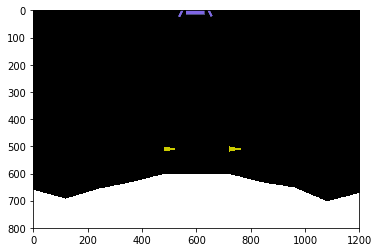

In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

env = gym.make("LunarLander-v2").env  #if you see "<classname> has no attribute .env", remove .env or update gym
env.reset()
n_actions = env.action_space.n

plt.imshow(env.render("rgb_array"))

In [2]:
from sklearn.neural_network import MLPClassifier
agent = MLPClassifier(hidden_layer_sizes=(200,200),
                      activation='tanh',
                      warm_start=True, #keep progress between .fit(...) calls
                      max_iter=1 #make only 1 iteration on each .fit(...)
                     )
#initialize agent to the dimension of state an amount of actions
agent.fit([env.reset()]*n_actions, list(range(n_actions)))

/anaconda3/envs/gym/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(200, 200), learning_rate='constant',
       learning_rate_init=0.001, max_iter=1, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=True)

In [3]:
def generate_session(t_max=1000):
    
    states,actions = [],[]
    total_reward = 0
    
    s = env.reset()
    
    for t in range(t_max):
        
        # a vector of action probabilities in current state
        probs = agent.predict_proba([s])[0] 
        
        a = np.random.choice(n_actions, p=probs)
        
        new_s, r, done, info = env.step(a)
        
        #record sessions like you did before
        states.append(s)
        actions.append(a)
        total_reward += r
        
        s = new_s
        if done: break
    return states, actions, total_reward

In [4]:
def select_elites(states_batch,actions_batch,rewards_batch,percentile=50):
    """
    Select states and actions from games that have rewards >= percentile
    :param states_batch: list of lists of states, states_batch[session_i][t]
    :param actions_batch: list of lists of actions, actions_batch[session_i][t]
    :param rewards_batch: list of rewards, rewards_batch[session_i][t]
    
    :returns: elite_states,elite_actions, both 1D lists of states and respective actions from elite sessions
    
    Please return elite states and actions in their original order 
    [i.e. sorted by session number and timestep within session]
    
    If you're confused, see examples below. Please don't assume that states are integers (they'll get different later).
    """
    
    reward_threshold = np.percentile(rewards_batch, percentile)
    
    elite_states  = [state for states, reward in zip(states_batch, rewards_batch) if reward >= reward_threshold for state in states]
    elite_actions = [action for actions, reward in zip(actions_batch, rewards_batch) if reward >= reward_threshold for action in actions]
    
    return elite_states,elite_actions

In [5]:
from IPython.display import clear_output

def show_progress(batch_rewards, log, percentile, reward_range=[-990,+10]):
    """
    A convenience function that displays training progress. 
    No cool math here, just charts.
    """
    
    mean_reward, threshold = np.mean(batch_rewards), np.percentile(batch_rewards, percentile)
    log.append([mean_reward, threshold])

    clear_output(True)
    print("mean reward = %.3f, threshold=%.3f"%(mean_reward, threshold))
    plt.figure(figsize=[8,4])
    plt.subplot(1,2,1)
    plt.plot(list(zip(*log))[0], label='Mean rewards')
    plt.plot(list(zip(*log))[1], label='Reward thresholds')
    plt.legend()
    plt.grid()
    
    plt.subplot(1,2,2)
    plt.hist(batch_rewards, range=reward_range);
    plt.vlines([np.percentile(batch_rewards, percentile)], [0], [100], label="percentile", color='red')
    plt.legend()
    plt.grid()

    plt.show()

In [6]:
from joblib import Parallel, delayed

mean reward = 51.342, threshold=57.464


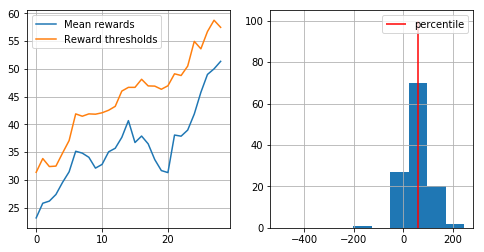

You Win! You may stop training now via KeyboardInterrupt.


In [8]:
n_sessions = 100
percentile = 70
log = []
sessions = Parallel(n_jobs=4)(delayed(generate_session)() for _ in range(100))

for i in range(100):
    #generate new sessions
    sessions += Parallel(n_jobs=4)(delayed(generate_session)() for _ in range(20))

    batch_states,batch_actions,batch_rewards = map(np.array, zip(*sessions))
    elite_states, elite_actions = select_elites(batch_states,batch_actions,batch_rewards)
    
    agent.fit(elite_states, elite_actions)

    show_progress(batch_rewards, log, percentile, reward_range=[-500,np.max(batch_rewards)])
    
    sessions = sessions[20:]
    if np.mean(batch_rewards) > 50:
        print("You Win! You may stop training now via KeyboardInterrupt.")
        break